# Prioritized Experience Replay DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

[2020-02-06 11:31:10,769] Making new env: MountainCar-v0
/Users/angga.muhammad/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(2,)
Action space Discrete(3)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa        

## Set Prioritized Replay Buffer

In [10]:
class PrioritizedReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, capacity):
        """Initialize a PrioritizedReplayMemory object."""
        
        self.PER_e = 0.01 # to avoid zero opportunity of getting selected
        self.PER_a = 0.6 # the probability of performing random sampling
        self.PER_b = 0.4 # to adjust weight update rule to match the underlying distribution
        
        self.capacity = capacity
        self.memory = []
        self.data_pointer = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)
        
        max_priority = self.priorities.max() if self.memory else 1.0
        
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            self.memory[self.data_pointer] = (state, action, reward, next_state, done)
            
        self.priorities[self.data_pointer] = max_priority
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        
    def sample(self):
        """Sample a batch of prioritized experiences from memory."""
        
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.data_pointer]
            
        # compute the sampling probabilities based on priorities values (not uniformly)
        probs = priorities ** self.PER_a
        probs/= probs.sum() 
        
        indices = np.random.choice(len(self.memory), BATCH_SIZE, p=probs)
        samples = [self.memory[index] for index in indices]
        
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.PER_b)
        weights/= weights.max()
        weights = np.array(weights, dtype=np.float32)
        
        experiences = list(zip(*samples))
        
        states = torch.from_numpy(np.vstack([np.concatenate(experiences[0])])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([np.expand_dims(experiences[1], axis=1)])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([np.expand_dims(experiences[2], axis=1)])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([np.concatenate(experiences[3])])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([np.expand_dims(experiences[4], axis=1)]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        weights = torch.from_numpy(np.expand_dims(weights, axis=1)).float()
        weights = weights.to(device)
        
        return indices, (states, actions, rewards, next_states, dones), weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        """Update current priorities of internal memory."""
        
        for batch_id, priority in zip(batch_indices, batch_priorities):
            self.priorities[batch_id] = priority
            
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define [PER DQN](https://arxiv.org/pdf/1511.05952.pdf) Agent

In [11]:
class PER_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = PrioritizedReplayBuffer(BUFFER_SIZE)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                batch_indices, experiences, weights = self.buffer.sample()
                self.learn(batch_indices, experiences, weights, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
            
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, batch_indices, experiences, weights, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss using PER concept
        loss  = torch.pow((Q_expected - Q_target), 2) * weights        
        priorities = loss + self.buffer.PER_e
        
        loss  = torch.mean(loss)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        self.buffer.update_priorities(batch_indices, priorities.data.cpu().numpy())
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = PER_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= -200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/PER_DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=800, max_time=1000)

Episode: 100, Average Score: -1000.00
Episode: 200, Average Score: -1000.00
Episode: 300, Average Score: -923.030
Episode: 400, Average Score: -614.03
Episode: 500, Average Score: -203.39
Episode: 506, Average Score: -199.31
Environment solved in 406 episodes! Average Score: -199.31
Episode: 507, Average Score: -199.02
Environment solved in 407 episodes! Average Score: -199.02
Episode: 508, Average Score: -199.56
Environment solved in 408 episodes! Average Score: -199.56
Episode: 509, Average Score: -198.68
Environment solved in 409 episodes! Average Score: -198.68
Episode: 510, Average Score: -198.42
Environment solved in 410 episodes! Average Score: -198.42
Episode: 511, Average Score: -197.75
Environment solved in 411 episodes! Average Score: -197.75
Episode: 512, Average Score: -198.96
Environment solved in 412 episodes! Average Score: -198.96
Episode: 513, Average Score: -198.68
Environment solved in 413 episodes! Average Score: -198.68
Episode: 514, Average Score: -198.91
Environ

Episode: 590, Average Score: -187.64
Environment solved in 490 episodes! Average Score: -187.64
Episode: 591, Average Score: -188.62
Environment solved in 491 episodes! Average Score: -188.62
Episode: 592, Average Score: -189.44
Environment solved in 492 episodes! Average Score: -189.44
Episode: 593, Average Score: -188.61
Environment solved in 493 episodes! Average Score: -188.61
Episode: 594, Average Score: -188.55
Environment solved in 494 episodes! Average Score: -188.55
Episode: 595, Average Score: -189.14
Environment solved in 495 episodes! Average Score: -189.14
Episode: 596, Average Score: -188.93
Environment solved in 496 episodes! Average Score: -188.93
Episode: 597, Average Score: -188.89
Environment solved in 497 episodes! Average Score: -188.89
Episode: 598, Average Score: -189.55
Environment solved in 498 episodes! Average Score: -189.55
Episode: 599, Average Score: -190.40
Environment solved in 499 episodes! Average Score: -190.40
Episode: 600, Average Score: -190.36

En

## Evaluate The Agent

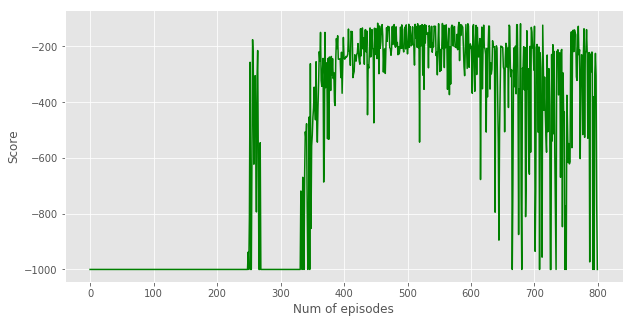

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/PER_DQN_{ENV_NAME}.pth'));

In [18]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(200):
        
        env.render() # render the screen
        
        action = policy.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

---